In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('/content/drive/MyDrive/datasets/movie.csv', sep=",")
X = dataset["text"]
y = dataset["label"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, stratify=y)

X_train, y_train

(21779    A terrific B-feature. A virtual two-hander and...
 7540     Well...I like Patricia Kaas. She is a beautifu...
 14467    I absolutely loved this movie. It met all expe...
 16045    Why was this film made? Even keeping in mind t...
 1073     This anime is a must-see for fans of Evangelio...
                                ...                        
 13326    Brilliant acting, excellent plot, wonderful sp...
 2078     This was just telecast here in the U.S. Others...
 35883    'Blue Desert' may have had the potential to be...
 29517    There's nothing new here. All the standard rom...
 38590    This satire is just really, really dead-on, an...
 Name: text, Length: 20000, dtype: object, 21779    1
 7540     0
 14467    1
 16045    0
 1073     1
         ..
 13326    0
 2078     0
 35883    0
 29517    0
 38590    1
 Name: label, Length: 20000, dtype: int64)

# CNN


In [4]:
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Embedding, TextVectorization, Dense, LSTM, Input, Reshape, Flatten, Conv2D, MaxPooling2D, Dropout

vectorize_layer = TextVectorization(
  max_tokens=50000,
  standardize="lower_and_strip_punctuation",
  output_sequence_length=100,
  pad_to_max_tokens=True,
)
vectorize_layer.adapt(X_train)

history_Adam = History()

model = Sequential()

# Vectorization
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# Embedding
model.add(Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=16, input_length=100))

#Embedding returns a tensor so we nee
model.add(Reshape((40, 40, 1), input_shape=(16,100)))
model.add(Conv2D(1,(3,3), input_shape=(16,16)))
model.add(Conv2D(1,(3,3), input_shape=(14,14), padding="same"))
model.add(Dropout(0.3))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(6,(2,2),padding="same"))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 16)           800000    
                                                                 
 reshape (Reshape)           (None, 40, 40, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 38, 38, 1)         10        
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 1)         10        
                                                                 
 dropout (Dropout)           (None, 38, 38, 1)         0         
                                                        

In [5]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[history_Adam, early_stopping])

Epoch 1/200
200/200 [==============================] - 7s 18ms/step - loss: 0.5880 - accuracy: 0.6548 - val_loss: 0.5287 - val_accuracy: 0.7468
Epoch 2/200
200/200 [==============================] - 3s 17ms/step - loss: 0.2963 - accuracy: 0.8771 - val_loss: 0.7202 - val_accuracy: 0.7199
Epoch 3/200
200/200 [==============================] - 3s 17ms/step - loss: 0.1385 - accuracy: 0.9520 - val_loss: 1.0189 - val_accuracy: 0.7087
Epoch 4/200
200/200 [==============================] - 3s 17ms/step - loss: 0.0557 - accuracy: 0.9836 - val_loss: 1.5067 - val_accuracy: 0.7058
Epoch 5/200
200/200 [==============================] - 3s 17ms/step - loss: 0.0233 - accuracy: 0.9935 - val_loss: 1.6492 - val_accuracy: 0.7219
Epoch 6/200
200/200 [==============================] - 4s 20ms/step - loss: 0.0114 - accuracy: 0.9970 - val_loss: 2.1938 - val_accuracy: 0.7008
Epoch 7/200
200/200 [==============================] - 3s 17ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 2.2021 - val_accuracy:

In [6]:
model.evaluate(X_test,y_test)

625/625 [==============================] - 3s 5ms/step - loss: 2.6026 - accuracy: 0.7304


[2.602591037750244, 0.7304499745368958]

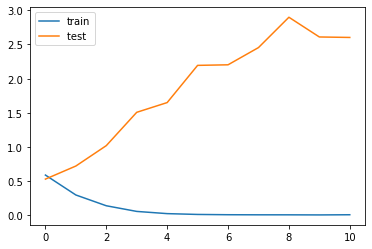

In [7]:
import matplotlib.pyplot as plt
plt.plot(history_Adam.history['loss'], label = "train")
plt.plot(history_Adam.history['val_loss'], label = "test ")
plt.legend()
plt.show()

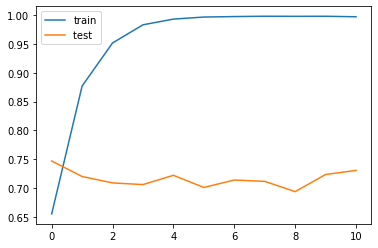

In [8]:
plt.plot(history_Adam.history['accuracy'], label = "train")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")
plt.legend()
plt.show()

# CNN with GloVe

https://arxiv.org/pdf/1904.04206.pdf \
https://nlp.stanford.edu/projects/glove/

In [9]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-06-08 19:38:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-06-08 19:38:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-08 19:38:38--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [10]:
vectorize_layer = TextVectorization(
  max_tokens=50000,
  standardize="lower_and_strip_punctuation",
  output_sequence_length=100,
  pad_to_max_tokens=True,
)
vectorize_layer.adapt(X_train)
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))



In [11]:
import os
import numpy as np

embeddings_index = {}
with open("/content/glove.6B.100d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 400000 word vectors.
Converted 40374 words (9626 misses)


In [12]:
from keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [14]:
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Embedding, TextVectorization, Dense, LSTM, Input, Reshape, Flatten, Conv2D, MaxPooling2D, Dropout

history_Adam = History()

model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(embedding_layer)

model.add(Reshape((100, 100, 1), input_shape=(100,100)))

model.add(Conv2D(1,(3,3), input_shape=(100,100)))
model.add(Conv2D(1,(3,3), input_shape=(98, 98), padding="same"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(1,(2,2),padding="same"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(6,(3,3), input_shape=(24, 24, 6)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(6,(3,3), input_shape=(12, 12, 6)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(6,(3,3), input_shape=(6, 6, 6)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 100, 100)          5000200   
                                                                 
 reshape_1 (Reshape)         (None, 100, 100, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 98, 1)         10        
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 98, 1)         10        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 1)        0         
 2D)                                                  

In [19]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=500, callbacks=[history_Adam, early_stopping])

Epoch 1/200
40/40 [==============================] - 5s 68ms/step - loss: 0.6160 - accuracy: 0.6573 - val_loss: 0.6224 - val_accuracy: 0.6539
Epoch 2/200
40/40 [==============================] - 3s 66ms/step - loss: 0.6161 - accuracy: 0.6586 - val_loss: 0.6202 - val_accuracy: 0.6544
Epoch 3/200
40/40 [==============================] - 3s 69ms/step - loss: 0.6141 - accuracy: 0.6588 - val_loss: 0.6223 - val_accuracy: 0.6535
Epoch 4/200
40/40 [==============================] - 3s 68ms/step - loss: 0.6145 - accuracy: 0.6615 - val_loss: 0.6199 - val_accuracy: 0.6562
Epoch 5/200
40/40 [==============================] - 3s 74ms/step - loss: 0.6173 - accuracy: 0.6563 - val_loss: 0.6224 - val_accuracy: 0.6526
Epoch 6/200
40/40 [==============================] - 3s 75ms/step - loss: 0.6153 - accuracy: 0.6597 - val_loss: 0.6300 - val_accuracy: 0.6492
Epoch 7/200
40/40 [==============================] - 3s 75ms/step - loss: 0.6147 - accuracy: 0.6610 - val_loss: 0.6307 - val_accuracy: 0.6477
Epoch 

In [20]:
model.evaluate(X_test,y_test)

625/625 [==============================] - 3s 5ms/step - loss: 0.6289 - accuracy: 0.6485


[0.6288773417472839, 0.6485000252723694]

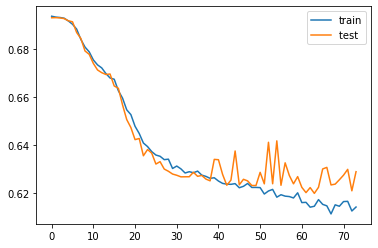

In [21]:
import matplotlib.pyplot as plt
plt.plot(history_Adam.history['loss'], label = "train")
plt.plot(history_Adam.history['val_loss'], label = "test ")
plt.legend()
plt.show()

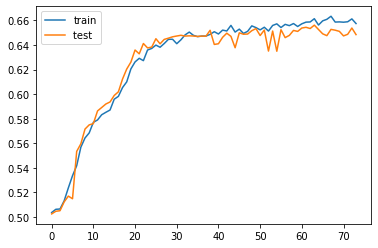

In [22]:
plt.plot(history_Adam.history['accuracy'], label = "train")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")
plt.legend()
plt.show()